# Virtual Internships Project

## Pre-processing and Cleaning

First we will import all relevant modules. We will then import our csv as a pandas dataframe for easy use.

In [72]:
import pandas as pd
import numpy as np

In [73]:
df = pd.read_csv('virtualInternshipData_ADS2001.csv', encoding= 'unicode_escape') #read the csv provided
df = df.drop("Unnamed: 0",axis=1) #drop the unnamed column
df.head() #print first several rows of data frame

,userIDs,implementation,Line_ID,ChatGroup,content,group_id,RoleName,roomName,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,OutcomeScore,wordCount
0,1,a,1,PRNLT,Hello team. Welcome to Nephrotex!,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,5
1,1,a,2,PRNLT,I'm Maria Williams. I'll be your design adviso...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,11
2,1,a,3,PRNLT,I'm here to help if you have any questions.,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,9
3,1,a,4,PRNLT,Please introduce yourselves with the name you ...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,1,0,0,4,51
4,1,a,5,PRNLT,I just want to make sure everyone has found th...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,39


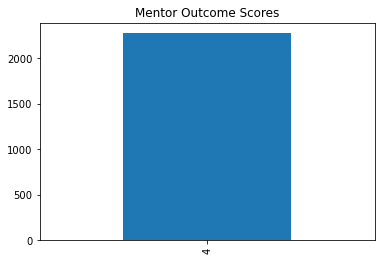

In [74]:
df[df['RoleName']=="Mentor"]["OutcomeScore"].value_counts().plot(kind='bar', title='Mentor Outcome Scores');

As we can see, if the certain user is a mentor, they are automatically assigned an outcome score of 4 which will be irrelevant for our model because we are trying to predict the player scores.

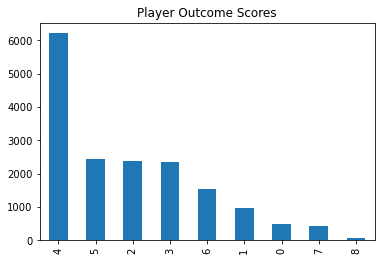

In [75]:
df[df['RoleName']=="Player"]["OutcomeScore"].value_counts().plot(kind='bar', title='Player Outcome Scores');

In [76]:
import copy
df = copy.deepcopy(df[df['RoleName']=="Player"]) #only get dataframe with Player
df = df.sort_values(by=['userIDs']) #to group outcome scores later on 
df = df.reset_index()

## Stop Words
When working with text or natural language, there are certain words that don't add any value to a sentence e.g. "this" and so we will need to remove these words. 

In [77]:
from nltk.corpus import stopwords 
import string

df['content'] = df['content'].str.lower() #make all the letters lowercase for easy of use

stop = stopwords.words('english') #import english stopwords from nltk 
additional_stopwords = ["i'm", "i'll", "ill"] #add any additional stop words not from nltk
stop = stop + additional_stopwords

df['content_without_stopwords'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #remove all stopwords in content column

df['content_without_stopwords'] = df['content_without_stopwords'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation))) #remove all punctuation

df['content_without_stopwords'] = df['content_without_stopwords'].apply(lambda x: "".join([i for i in x if not i.isdigit()])) #remove all digits

print('With stop words: ' + df['content'][0])
print('Without stop words: ' + df['content_without_stopwords'][0])

With stop words: hello i am brandon!
Without stop words: hello brandon


## Tokenizing

In natural language processing, each document or sentence can thought of as a bag of words in the form of a list where each element is a word...

In [78]:
from nltk.tokenize import word_tokenize
df['content_tokenized'] = df.apply(lambda row: word_tokenize(row['content_without_stopwords']), axis=1) #tokenize all the content

Splitting the document up like this is called <u>tokenizing</u>.

In [79]:
df['content_tokenized'][0]

['hello', 'brandon']

In [80]:
#all words found in the content
word_set = set().union(*df['content_tokenized'])
print("Number of words: " + str(len(word_set)))
print(list(word_set)[:20]) #print first 20 words of word set

Number of words: 5569
['methods', 'cuts', 'attached', 'xing', 'logic', 'needing', 'paramaters', 'tell', 'weather', 'benchmark', 'correlate', 'proficiency', 'ontrol', 'serve', 'tweaks', 'previous', 'negavtive', 'does', 'laddies', 'selected']


In [81]:
#splitting each sublist into all content said by each user
user_dict = [] #creating an empty list to store all the sublist of all the words said by each user
for idx in df['userIDs'].unique(): #loop over every unique id
    lst = [word_tokenize(i) for i in df[df['userIDs'] == idx]['content_without_stopwords'].to_list()] #tokenize the contents of each row
    tokenized_sents = [item for sublist in lst for item in sublist] #re-formatting 
    tokenized_sents_with_id = [idx, tokenized_sents]
    user_dict.append(tokenized_sents_with_id) #append the sublist into the user_dict list

In [153]:
print(user_dict[0][1][:10]) #printing all content that user 2 said

['hello', 'brandon', 'using', 'negative', 'hydrophillic', 'amount', 'nano', 'tubes', 'filter', 'thank']


In [133]:
#creating a list where each sublist is a dictionary that counts the frequency of all the words that are used by a user
word_dict = [] #create an empty list to store all the words used
for i in range(len(user_dict)):
    #creating dictionaries to keep count of the words
    temp_word_dict = dict.fromkeys(word_set, 0)
    word_dict.append(temp_word_dict) #append each dictionary to the word dictionary 
    
    #count the words in the bag of words for each user
    for word in user_dict[i][1]:
        word_dict[i][word] += 1

In [151]:
print(list(word_dict[0].items())[:10]) #printing the first 10 dictionary words of user 2

[('methods', 0), ('cuts', 0), ('attached', 0), ('xing', 0), ('logic', 0), ('needing', 0), ('paramaters', 0), ('tell', 2), ('weather', 0), ('benchmark', 0)]


## TF-IDF

Rather than just counting, we can use <u>TF-IDF</u>, short for term frequency-inverse document frequency to rank a word on it's importance.

The <u>TF-IDF</u> score of a word $ w $ is: $ tf(w) * idf(w) $

Where $ tf(w) $ = frequency of word in a document / total number of words in the document

And where $ idf(w) $ = $\log$(number of documents / number of documents that contain word $ w $)

In [85]:
def computeTF(word_dict, user_dict):
    tf_dict = {}
    user_dict_count = len(user_dict)
    for word, count in word_dict.items():
        if user_dict_count == 0:
            tf_dict[word] = 0
        else:
            tf_dict[word] = count / float(user_dict_count)
    return tf_dict

def computeIDF(doc_list):
    import math
    idf_dict = {}
    n = len(doc_list)

    idf_dict = dict.fromkeys(doc_list[0].keys(),0)
    for doc in doc_list:
        for word, val in doc.items():
            if val > 0:
                idf_dict[word] += 1

    for word, val in idf_dict.items():
        idf_dict[word] = math.log(n / float(val), 10)

    return idf_dict

def computeTFIDF(tf_user_dict, idfs):
    tfidf = {}
    for word, val in tf_user_dict.items():
        tfidf[word] = val * idfs[word]
    return tfidf

### Example of TF-IDF

Suppose we have two documents as listed below. The calculation of <u>TF-IDF</u> for the term "hello" is performed as: 

The <u>TF</u>, is the frequency that the word "hello" appears in each document. In each document, the word appears once; but as document 1 (index 0) has more words, its relative frequency is smaller.

$$ tf('charge', doc1) = \frac{1}{2} = 0.5 $$
$$ tf('charge', doc2) = \frac{1}{3} \approx 0.33 $$

An <u>IDF</u> accounts for the ratio of documents that include the word "hello". In this case, we have a total of two documents and all of them include the word "hello".

$$ idf('charge', documents) = log(\frac{2}{2}) = 0 $$

So <u>TF-IDF</u> is 0 for the word "hello" implying that the word is not very informative as it appears in all documents.

$$ tfidf('charge', doc1, documents) = 0.5 * 0 = 0 $$
$$ tfidf('charge', doc2, documents) = 0.33 * 0 = 0 $$

Take the word "team", it occurs once only in document 1:

$$ tf('hydrophilic', doc1) = \frac{0}{2} = 0 $$
$$ tf('hydrophilic', doc2) = \frac{1}{3} \approx 0.33 $$
$$ idf('hydrophilic', documents) = log(\frac{2}{1}) \approx 0.301 $$

Therefore,

$$ tfidf('hydrophilic', doc1, documents) = tf('hydrophilic', doc1) * idf('hydrophilic', documents) = 0 * 0.301 = 0 $$
$$ tfidf('hydrophilic', doc2, documents) = tf('hydrophilic', doc2) * idf('hydrophilic', documents) = 0.33 * 0.301 \approx 0.1 $$

In [86]:
doc1 = word_tokenize(df['content_without_stopwords'][19])
doc2 = word_tokenize(df['content_without_stopwords'][21])

word_set_example = set(doc1).union(set(doc2))
word_dict1 = dict.fromkeys(word_set_example, 0)
word_dict2 = dict.fromkeys(word_set_example, 0)

for word in doc1:
    word_dict1[word] += 1

for word in doc2:
    word_dict2[word] += 1

pd.DataFrame([word_dict1, word_dict2])

,hydrophilic,negative,charge
0,0,1,1
1,1,1,1


In [87]:
tf1_example = computeTF(word_dict1, doc1)
tf2_example = computeTF(word_dict2, doc2)

idf_example = computeIDF([word_dict1, word_dict2])

tfidf1_example = computeTFIDF(tf1_example, idf_example)
tfidf2_example = computeTFIDF(tf2_example, idf_example)

word1 = "charge"
print(word1)
print("tf for document 1: " + str(tf1_example[word1]))
print("tf for document 2: " + str(tf2_example[word1]))
print("idf for documents: " + str(idf_example[word1]))
print("tfidf for document 1: " + str(tfidf1_example[word1]))
print("tfidf for document 2: " + str(tfidf2_example[word1]))
print("")

word2 = "hydrophilic"
print(word2)
print("tf for document 1: " + str(tf1_example[word2]))
print("tf for document 2: " + str(tf2_example[word2]))
print("idf for documents: " + str(idf_example[word2]))
print("tfidf for document 1: " + str(tfidf1_example[word2]))
print("tfidf for document 2: " + str(tfidf2_example[word2]))

charge
tf for document 1: 0.5
tf for document 2: 0.3333333333333333
idf for documents: 0.0
tfidf for document 1: 0.0
tfidf for document 2: 0.0

hydrophilic
tf for document 1: 0.0
tf for document 2: 0.3333333333333333
idf for documents: 0.30102999566398114
tfidf for document 1: 0.0
tfidf for document 2: 0.10034333188799371


In [88]:
idfs = computeIDF(word_dict) #compute idf
tfidf = [] #create empty list to append tf-idf values
for i in range(len(user_dict)): 
    temp_tf_user_dict = computeTF(word_dict[i], user_dict[i][1]) #compute tf
    temp_tfidf_user_dict = computeTFIDF(temp_tf_user_dict, idfs) #compute tf-idf
    tfidf.append(temp_tfidf_user_dict) #append tf-idf values into list

In [89]:
df_tfidf = pd.DataFrame.from_records(tfidf) #make the matrix into a dataframe

idx = [user_dict[i][0] for i in range(len(user_dict))]
df_tfidf.index = idx

outcome_score = df.drop_duplicates(subset=['userIDs'])['OutcomeScore'].to_numpy() #grab outcome score of each individual user
df_tfidf['outcome_score'] = outcome_score

df_tfidf.head() #print the first several rows

,methods,cuts,attached,xing,logic,needing,paramaters,tell,weather,benchmark,...,determined,coatings,orders,membrane,icon,fewest,common,calss,performer,outcome_score
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006479,0.0,0.0,...,0.003778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Resampling using Imbalanced-learn
Since the dataset is so imbalanced, consisting of mainly outcome scores of 4, using metrics like `accuracy_score` can be misleading. Therefore, we need to use resampling in orde to remove samples from the majority class (under-sampling) and adding more samples from the minority class (over-sampling).

In [90]:
random_state = 1 #initialise random_state we want to test

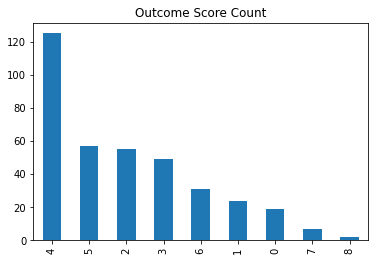

In [91]:
outcome_score_count = df_tfidf['outcome_score'].value_counts()
outcome_score_count.plot(kind='bar', title='Outcome Score Count');

In [92]:
X = df_tfidf[df_tfidf.drop(columns=['outcome_score']).columns]
y = df_tfidf['outcome_score']

In [93]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=random_state) #random_state to an integer to make sure examples are repeatable
X_ros, y_ros = ros.fit_resample(X, y)
print("Number of users after over sampling: " + str(len(X_ros)))

Number of users after over sampling: 1125


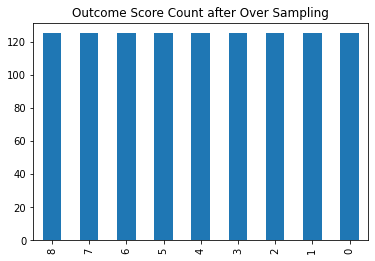

In [94]:
outcome_score_count = y_ros.value_counts()
outcome_score_count.plot(kind='bar', title='Outcome Score Count after Over Sampling');

## Feature Selection
Since our current dataset has so many features, currently with 5569 columns, a technique we can use to reduce the number of features is feature selection where we reduce the number of irrelevant features in the dataset. 

### Pearson Correlation

We check the absolute value of the Pearson’s correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion.

$$ r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2}\sum(y_i - \bar{y})^2} $$
$r$ = correlation coefficient   
$x_i$ = values of the x-variable in a sample  
$\bar{x}$ = mean of the values of the x-variable  
$y_i$ = values of the y-variable in a sample  
$\bar{y}$ = mean of the values of the y-variable

In [95]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [96]:
def generate_cor_feature(X, y, num_feats):
    feature_name = list(X.columns)
    # no of maximum features we need to select
    cor_support, cor_feature = cor_selector(X, y, num_feats)
    return cor_feature

In [97]:
cor_feature = generate_cor_feature(X_ros, y_ros, 3000)
print(str(len(cor_feature)), 'selected features')

3000 selected features


In [98]:
cor_feature[:10]

['accidental',
 'volunteering',
 'extensively',
 'invited',
 'notification',
 'polyrenalateprnltnonotube',
 'chosing',
 'revision',
 'ratesand',
 'expressed']

### Chi-Square Features
we calculate the chi-square metric between the target and the numerical variable and only select the variable with the maximum chi-squared values.

$$ X^2 = \sum\frac{(O_i - E_i)^2}{E_i} $$
$ X^2 $ = chi squared  
$ O_i $ = observed value  
$ E_i $ = expected value

In [99]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

def generate_chi_feature(X, y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    return chi_feature

In [100]:
chi_feature = generate_chi_feature(X_ros, y_ros, 3000)
print(str(len(chi_feature)), 'selected features')

3000 selected features


In [101]:
chi_feature[:10]

['methods',
 'cuts',
 'xing',
 'logic',
 'paramaters',
 'weather',
 'correlate',
 'previous',
 'laddies',
 'selected']

### Lasso: Select From Model
Lasso's norm regularizer forces feature weights to be zero and so the higher the value of alpha the fewer features that have non-zero values.

In [102]:
from sklearn.feature_selection import SelectFromModel #for selecting features
from sklearn.linear_model import LogisticRegression #import the logistic regression model

def generate_lr_feature(X, y, max_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    lr_selector = SelectFromModel(LogisticRegression(solver="liblinear", penalty="l1", random_state=random_state), max_features=max_feats) #lasso regression uses L1 norm as regularizer and random_state to an integer to make sure examples are repeatable
    lr_selector.fit(X_norm, y)
    lr_support = lr_selector.get_support()
    lr_feature = X.loc[:,lr_support].columns.tolist()
    return lr_feature

In [103]:
lr_feature = generate_lr_feature(X_ros, y_ros, 3000)
print(str(len(lr_feature)), 'selected features')

724 selected features
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [104]:
lr_feature[:10]

['paramaters',
 'previous',
 'morning',
 'certain',
 'insight',
 'space',
 'last',
 'rating',
 'however',
 'ultra']

### Tree-Based: Select From Model
Random Forest calculates the final feature importance by taking the average of all decision tree feature importance.

In [105]:
from sklearn.ensemble import RandomForestClassifier
def generate_rf_feature(X, y, max_feats):
    rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), max_features=max_feats)
    rf_selector.fit(X, y)
    rf_support = rf_selector.get_support()
    rf_feature = X.loc[:,rf_support].columns.tolist()
    return rf_feature

In [106]:
rf_feature = generate_rf_feature(X_ros, y_ros, 3000)
print(str(len(rf_feature)), 'selected features')

1059 selected features


In [107]:
rf_feature[:10]

['methods',
 'xing',
 'tell',
 'previous',
 'selected',
 'still',
 'morning',
 'sway',
 'typically',
 'concerns']

## Classification Models

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

### Logistic Regression

In [109]:
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
# split the data into 80% training and 20% testing, random_state to an integer ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X_ros,y_ros,train_size=0.8,random_state=random_state)

In [110]:
def generate_lr_model(X_train, X_test, y_train):
    # penalty='none' implies no regularization and solver='lbfgs' is the default solver
    model = LogisticRegression(solver='lbfgs', penalty='none', max_iter=4000, random_state=random_state)
    # fit the training data to the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    return model, y_pred, y_pred_proba

In [111]:
model, y_pred, y_pred_proba = generate_lr_model(X_train, X_test, y_train)

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions 
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test, y_pred, axs=None, title="", fontsize = 12):
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues", annot=True, linewidths=.5, ax=axs)
    ax.set_title('Confusion Matrix' + title + "\n Accuracy: " + str(accuracy_score(y_test, y_pred)), fontsize=fontsize) # add a title
    ax.set_ylabel('Actual label') # add a ylabel
    ax.set_xlabel('Predicted label') # add a xlabel

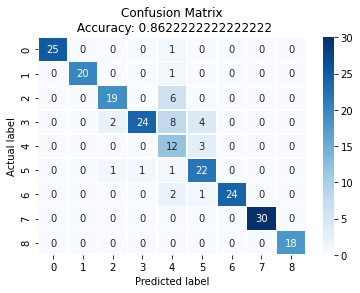

In [113]:
#plot confusion matrix 
plot_confusion_matrix(y_pred, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


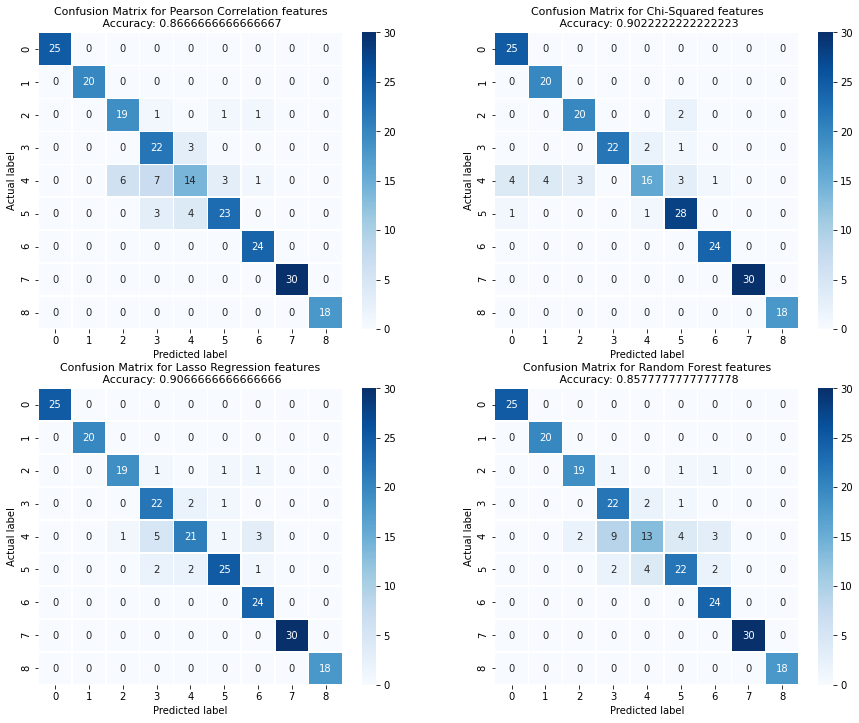

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
cor_feature = generate_cor_feature(X_ros, y_ros, 1800)
chi_feature = generate_chi_feature(X_ros, y_ros, 3500)
lr_feature = generate_lr_feature(X_ros, y_ros, 600)
rf_feature = generate_rf_feature(X_ros, y_ros, 700)
features = [cor_feature, chi_feature, lr_feature, rf_feature]
titles = ["Pearson Correlation", "Chi-Squared", "Lasso Regression", "Random Forest"]
i_n = [0, 0, 1, 1]
j_n = [0, 1, 0, 1]
for i, j, feature, title in zip(i_n, j_n, features, titles):
    X_train,X_test,y_train,y_test=train_test_split(X_ros[[*feature]],y_ros,train_size=0.8,random_state=random_state)
    model, y_pred, y_pred_proba = generate_lr_model(X_train, X_test, y_train)
    full_title = " for " + title + " features"
    plot_confusion_matrix(y_test, y_pred, axs[i, j], full_title, 11)

Choosing 1800 Pearson Correlation features provides an accuracy of approximately 86% for the Logistic Regression model

Choosing 3500 Chi-Squared features provides an accuracy of approximately 87% for the Logistic Regression model

Choosing 600 Lasso Regression features provides an accuracy of approximately 92% for the Logistic Regression model

Choosing 700 Random Forest features provides an accuracy of approximately 87% for the Logistic Regression model

### Naïve Bayes
Naive Bayes algorithm based on Bayes’ theorem with the assumption of independence between every pair of features.

In [115]:
# split the data into 80% training and 20% testing, random_state to an integer ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X_ros,y_ros,train_size=0.8,random_state=random_state)

In [116]:
from sklearn.naive_bayes import GaussianNB
def generate_gnb_model(X_train, X_test, y_train):
    model = GaussianNB() 
    # fit the training data to the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    return model, y_pred, y_pred_proba

In [117]:
model, y_pred, y_pred_proba = generate_gnb_model(X_train, X_test, y_train)

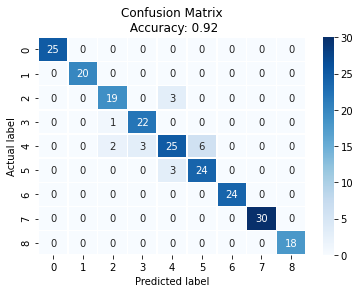

In [118]:
#plot confusion matrix 
plot_confusion_matrix(y_pred, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


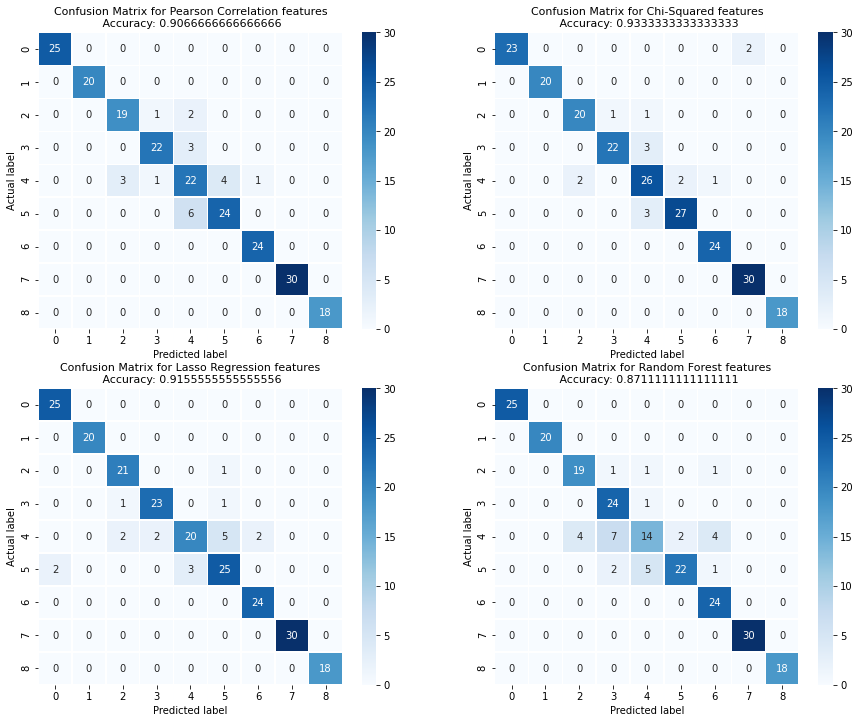

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
cor_feature = generate_cor_feature(X_ros, y_ros, 4800)
chi_feature = generate_chi_feature(X_ros, y_ros, 3500)
lr_feature = generate_lr_feature(X_ros, y_ros, 700)
rf_feature = generate_rf_feature(X_ros, y_ros, 900)
features = [cor_feature, chi_feature, lr_feature, rf_feature]
titles = ["Pearson Correlation", "Chi-Squared", "Lasso Regression", "Random Forest"]
i_n = [0, 0, 1, 1]
j_n = [0, 1, 0, 1]
for i, j, feature, title in zip(i_n, j_n, features, titles):
    X_train,X_test,y_train,y_test=train_test_split(X_ros[[*feature]],y_ros,train_size=0.8,random_state=random_state)
    model, y_pred, y_pred_proba = generate_gnb_model(X_train, X_test, y_train)
    full_title = " for " + title + " features"
    plot_confusion_matrix(y_test, y_pred, axs[i, j], full_title, 11)

Choosing 4800 Pearson Correlation features provides an accuracy of approximately 88% for the Naive Bayes model

Choosing 3500 Chi-Squared features provides an accuracy of approximately 90% for the Naive Bayes model

Choosing 700 Lasso Regression features provides an accuracy of approximately 86% for the Naive Bayes model

Choosing 900 Random Forest features provides an accuracy of approximately 84% for the Naive Bayes model

### Decision Trees

In [120]:
# split the data into 80% training and 20% testing, random_state to an integer ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X_ros,y_ros,train_size=0.8,random_state=random_state)

In [121]:
from sklearn.tree import DecisionTreeClassifier
def generate_dtc_model(X_train, X_test, y_train):
    model = DecisionTreeClassifier(max_depth = 150, random_state=random_state) #random_state to an integer to make sure examples are repeatable
    # fit the training data to the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    return model, y_pred, y_pred_proba

In [122]:
model, y_pred, y_pred_proba = generate_dtc_model(X_train, X_test, y_train)

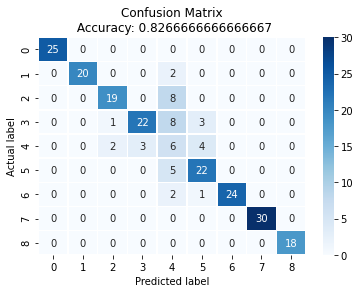

In [123]:
#plot confusion matrix 
plot_confusion_matrix(y_pred, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


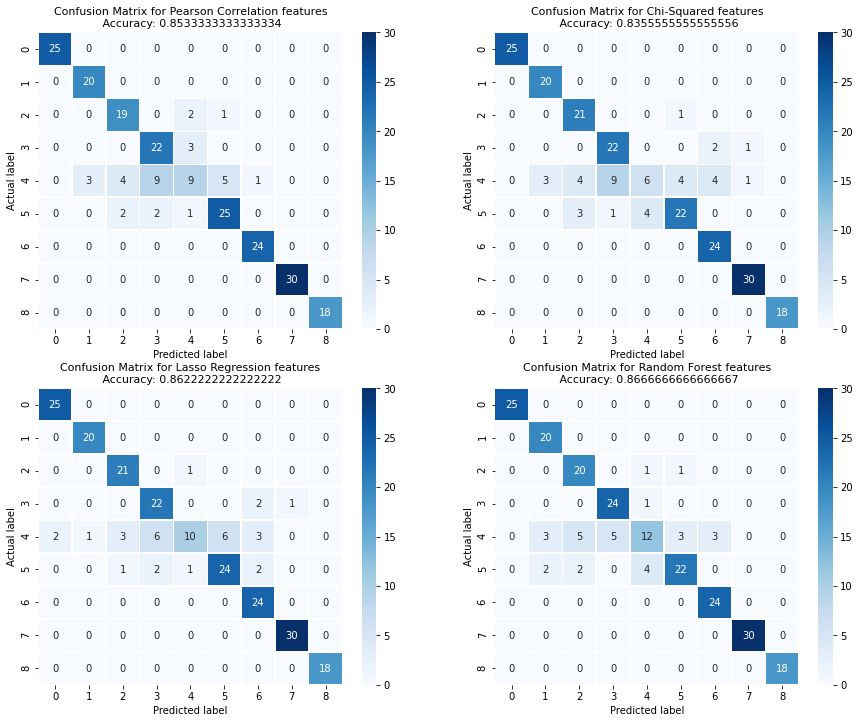

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
cor_feature = generate_cor_feature(X_ros, y_ros, 2800)
chi_feature = generate_chi_feature(X_ros, y_ros, 3300)
lr_feature = generate_lr_feature(X_ros, y_ros, 400)
rf_feature = generate_rf_feature(X_ros, y_ros, 300)
features = [cor_feature, chi_feature, lr_feature, rf_feature]
titles = ["Pearson Correlation", "Chi-Squared", "Lasso Regression", "Random Forest"]
i_n = [0, 0, 1, 1]
j_n = [0, 1, 0, 1]
for i, j, feature, title in zip(i_n, j_n, features, titles):
    X_train,X_test,y_train,y_test=train_test_split(X_ros[[*feature]],y_ros,train_size=0.8,random_state=random_state)
    model, y_pred, y_pred_proba = generate_dtc_model(X_train, X_test, y_train)
    full_title = " for " + title + " features"
    plot_confusion_matrix(y_test, y_pred, axs[i, j], full_title, 11)

Choosing 2800 Pearson Correlation features provides an accuracy of approximately 87% for the Decision Trees model

Choosing 3300 Chi-Squared features provides an accuracy of approximately 85% for the Decision Trees model

Choosing 400 Lasso Regression features provides an accuracy of approximately 87% for the Decision Trees model

Choosing 300 Random Forest features provides an accuracy of approximately 85% for the Decision Trees model

### Random Forest 

In [125]:
# split the data into 80% training and 20% testing, random_state to an integer ensures that the results are repeatable
X_train,X_test,y_train,y_test=train_test_split(X_ros,y_ros,train_size=0.8,random_state=random_state)

In [126]:
from sklearn.ensemble import RandomForestClassifier
def generate_rfc_model(X_train, X_test, y_train):
    model = RandomForestClassifier(random_state=random_state) #random_state to an integer to make sure examples are repeatable
    # fit the training data to the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    return model, y_pred, y_pred_proba

In [127]:
model, y_pred, y_pred_proba = generate_rfc_model(X_train, X_test, y_train)

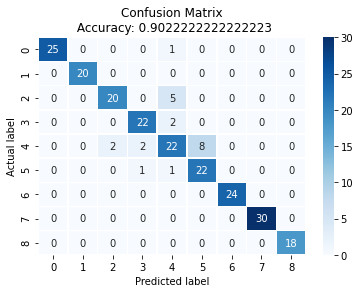

In [128]:
#plot confusion matrix 
plot_confusion_matrix(y_pred, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


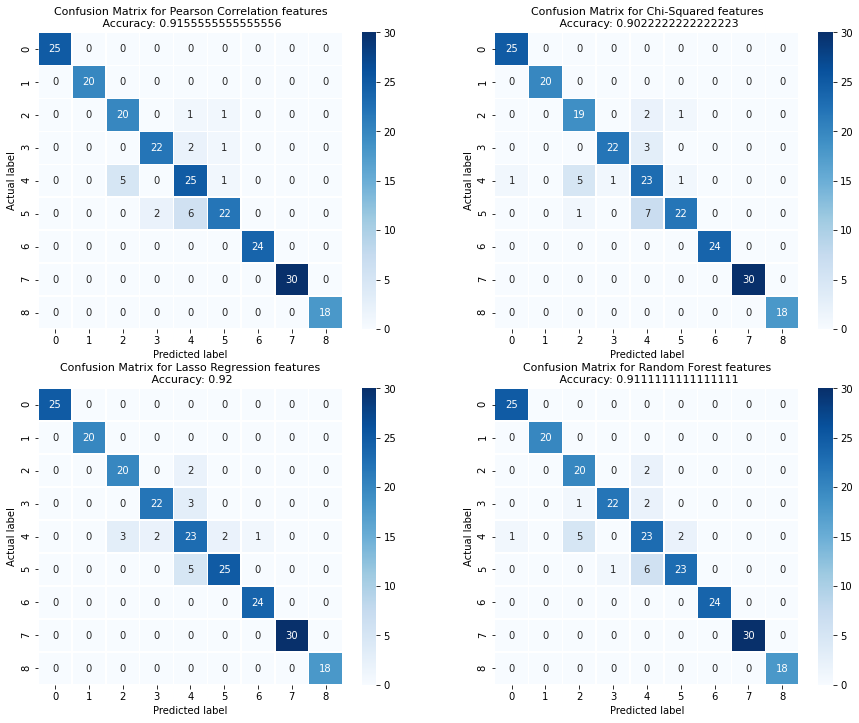

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
cor_feature = generate_cor_feature(X_ros, y_ros, 2800)
chi_feature = generate_chi_feature(X_ros, y_ros, 5000)
lr_feature = generate_lr_feature(X_ros, y_ros, 600)
rf_feature = generate_rf_feature(X_ros, y_ros, 600)
features = [cor_feature, chi_feature, lr_feature, rf_feature]
titles = ["Pearson Correlation", "Chi-Squared", "Lasso Regression", "Random Forest"]
i_n = [0, 0, 1, 1]
j_n = [0, 1, 0, 1]
for i, j, feature, title in zip(i_n, j_n, features, titles):
    X_train,X_test,y_train,y_test=train_test_split(X_ros[[*feature]],y_ros,train_size=0.8,random_state=random_state)
    model, y_pred, y_pred_proba = generate_rfc_model(X_train, X_test, y_train)
    full_title = " for " + title + " features"
    plot_confusion_matrix(y_test, y_pred, axs[i, j], full_title, 11)

Choosing 2800 Pearson Correlation features provides an accuracy of approximately 87% for the Decision Trees model

Choosing 5000 Chi-Squared features provides an accuracy of approximately 87% for the Decision Trees model

Choosing 600 Lasso Regression features provides an accuracy of approximately 90% for the Decision Trees model

Choosing 600 Random Forest features provides an accuracy of approximately 87% for the Decision Trees model

### Optimising Feature Selection

In [130]:
def optimise_feature_selection(model_tyle, iter_interval=100):
    best_cor_acc = 0
    best_cor_num = 0
    best_chi_acc = 0
    best_chi_num = 0
    best_lr_acc = 0
    best_lr_num = 0
    best_rf_acc = 0
    best_rf_num = 0
    if model_type == 'lr':
        for num_feats in range(iter_interval, len(word_set), iter_interval):
            cor_feature = generate_cor_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*cor_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_lr_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_cor_acc:
                best_cor_num = num_feats
                best_cor_acc = accuracy
            chi_feature = generate_chi_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*chi_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_lr_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_chi_acc:
                best_chi_num = num_feats
                best_chi_acc = accuracy
            lr_feature = generate_lr_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*lr_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_lr_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_lr_acc:
                best_lr_num = num_feats
                best_lr_acc = accuracy
            rf_feature = generate_rf_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*rf_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_lr_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_rf_acc:
                best_rf_num = num_feats
                best_rf_acc = accuracy

    if model_type == 'gnb':
        for num_feats in range(iter_interval, len(word_set), iter_interval):
            cor_feature = generate_cor_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*cor_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_gnb_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_cor_acc:
                best_cor_num = num_feats
                best_cor_acc = accuracy
            chi_feature = generate_chi_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*chi_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_gnb_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_chi_acc:
                best_chi_num = num_feats
                best_chi_acc = accuracy
            lr_feature = generate_lr_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*lr_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_gnb_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_lr_acc:
                best_lr_num = num_feats
                best_lr_acc = accuracy
            rf_feature = generate_rf_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*rf_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_gnb_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_rf_acc:
                best_rf_num = num_feats
                best_rf_acc = accuracy

    if model_type == 'dtc':
        for num_feats in range(iter_interval, len(word_set), iter_interval):
            cor_feature = generate_cor_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*cor_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_dtc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_cor_acc:
                best_cor_num = num_feats
                best_cor_acc = accuracy
            chi_feature = generate_chi_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*chi_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_dtc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_chi_acc:
                best_chi_num = num_feats
                best_chi_acc = accuracy
            lr_feature = generate_lr_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*lr_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_dtc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_lr_acc:
                best_lr_num = num_feats
                best_lr_acc = accuracy
            rf_feature = generate_rf_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*rf_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_dtc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_rf_acc:
                best_rf_num = num_feats
                best_rf_acc = accuracy

    if model_type == 'rfc':
        for num_feats in range(iter_interval, len(word_set), iter_interval):
            cor_feature = generate_cor_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*cor_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_rfc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_cor_acc:
                best_cor_num = num_feats
                best_cor_acc = accuracy
            chi_feature = generate_chi_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*chi_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_rfc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_chi_acc:
                best_chi_num = num_feats
                best_chi_acc = accuracy
            lr_feature = generate_lr_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*lr_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_rfc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_lr_acc:
                best_lr_num = num_feats
                best_lr_acc = accuracy
            rf_feature = generate_rf_feature(X_ros, y_ros, num_feats)
            X_train,X_test,y_train,y_test=train_test_split(X_ros[[*rf_feature]],y_ros,train_size=0.8,random_state=random_state)
            model, y_pred, y_pred_proba = generate_rfc_model(X_train, X_test, y_train)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_rf_acc:
                best_rf_num = num_feats
                best_rf_acc = accuracy

    print("Best accuracy for Pearson Correlation features: " + str(best_cor_acc) + " with " + str(best_cor_num) + " features.")
    print("Best accuracy for Chi-Squared features: " + str(best_chi_acc) + " with " + str(best_chi_num) + " features.")
    print("Best accuracy for Lasso Regression features: " + str(best_lr_acc) + " with " + str(best_lr_num) + " features.")
    print("Best accuracy for Random Forest features: " + str(best_rf_acc) + " with " + str(best_rf_num) + " features.")